# Lambda School Data Science - Ridge Regression

Regularize your way to a better tomorrow.

# Lecture

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

## Stop and think - what are ways to address these issues?

Let's examine in the context of housing data.

In [ ]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization!
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

In [ ]:
df.shape

In [ ]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

## Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...


In [ ]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

In [ ]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

In [ ]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

How to tune alpha? For now, let's loop and try values.

(For longterm/stretch/next week, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).)

In [ ]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

In [ ]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

## What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

In [ ]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

In [ ]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

In [ ]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

In [ ]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

## And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

## Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

```
Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression
```

In [ ]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

# Assignment

Following is data describing characteristics of blog posts, with a target feature of how many comments will be posted in the following 24 hours.

https://archive.ics.uci.edu/ml/datasets/BlogFeedback

Investigate - you can try both linear and ridge. You can also sample to smaller data size and see if that makes ridge more important. Don't forget to scale!

Focus on the training data, but if you want to load and compare to any of the test data files you can also do that.

Note - Ridge may not be that fundamentally superior in this case. That's OK! It's still good to practice both, and see if you can find parameters or sample sizes where ridge does generalize and perform better.

When you've fit models to your satisfaction, answer the following question:

```
Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
```

You can create whatever plots, tables, or other results support your argument. In this case, your target audience is a fellow data scientist, *not* a layperson, so feel free to dig in!

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import zipfile 
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import linear_model




In [2]:
zf = zipfile.ZipFile('C:/Users/dakot/Downloads/BlogFeedback.zip')
df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[0]), header= None) 
df1 = pd.DataFrame(scale(df))
# prediction is col 280 

In [4]:
df1.isnull().sum().sum()
X = df1.drop(columns= 280, axis = 'columns')
y = df1[280]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
lin_reg_split = LinearRegression().fit(X_train, y_train)
print('OLS_MSE:',mean_squared_error(y, lin_reg_split.predict(X)))
print('OLS_MSE-test:',mean_squared_error(y_test, lin_reg_split.predict(X_test)))

OLS_MSE: 0.052143057158775874
OLS_MSE-test: 0.2067741921813526


In [6]:
# Straight ridge reg
ridge_reg = Ridge().fit(X, y)
print('RIDGEREG_MSE:',mean_squared_error(y, ridge_reg.predict(X)))
print('RIDGEREG_MSE-test:',mean_squared_error(y_test, ridge_reg.predict(X_test)))

RIDGEREG_MSE: 0.0009201431249762766
RIDGEREG_MSE-test: 0.0015154561546771915


In [7]:
alphas = []
mses = []

for alpha in range(0, 50, 1):
  ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

0 0.2067741921833127
1 0.1549669081077962
2 0.15254617898141626
3 0.15045873375196453
4 0.14908157623009965
5 0.14824401916908655
6 0.14779096614184262
7 0.14761309192015074
8 0.14763533333068143
9 0.1478055556258185
10 0.14808682880800722
11 0.1484524525816627
12 0.14888275072379317
13 0.14936297228916615
14 0.14988188930690244
15 0.15043084016743088
16 0.1510030639597867
17 0.1515932286372082
18 0.15219709085225627
19 0.1528112468875765
20 0.15343294768956392
21 0.15405995972216335
22 0.1546904590480764
23 0.15532294982753841
24 0.15595620098154192
25 0.15658919652119233
26 0.1572210962667249
27 0.15785120454194965
28 0.15847894504600782
29 0.15910384054973686
30 0.15972549638949168
31 0.16034358697162837
32 0.16095784468005184
33 0.16156805071399907
34 0.1621740274854643
35 0.16277563228383526
36 0.16337275197552262
37 0.163965298553064
38 0.16455320538466578
39 0.16513642404380605
40 0.16571492162117657
41 0.16628867843926712
42 0.16685768610428056
43 0.16742194584164746
44 0.16798

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.474318e-19
  overwrite_a=False)


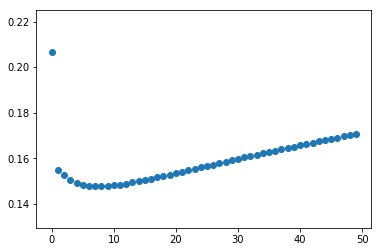

In [8]:
plt.scatter(alphas, mses);

In [9]:
#alpha = 7 looks to be the best 
#lets try sampling
dfsm = df1.sample(100,random_state = 42)
dfsm.shape
X1 =dfsm.drop(columns = [280],axis = 'columns')
y1 = dfsm[280]
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
lin_reg_split = LinearRegression().fit(X1, y1)
print('OLS_MSE:',mean_squared_error(y1, lin_reg_split.predict(X1)))
print('OLS_MSE-test:',mean_squared_error(y_test, lin_reg_split.predict(X_test)))
ridge_reg = Ridge(alpha = 7).fit(X1, y1)
print('RIDGEREG_MSE:',mean_squared_error(y1, ridge_reg.predict(X1)))
print('RIDGEREG_MSE-test:',mean_squared_error(y_test, ridge_reg.predict(X_test)))


OLS_MSE: 4.319965924739036e-29
OLS_MSE-test: 3.299845996254313e-29
RIDGEREG_MSE: 0.003313199097319256
RIDGEREG_MSE-test: 0.001998930438218585


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


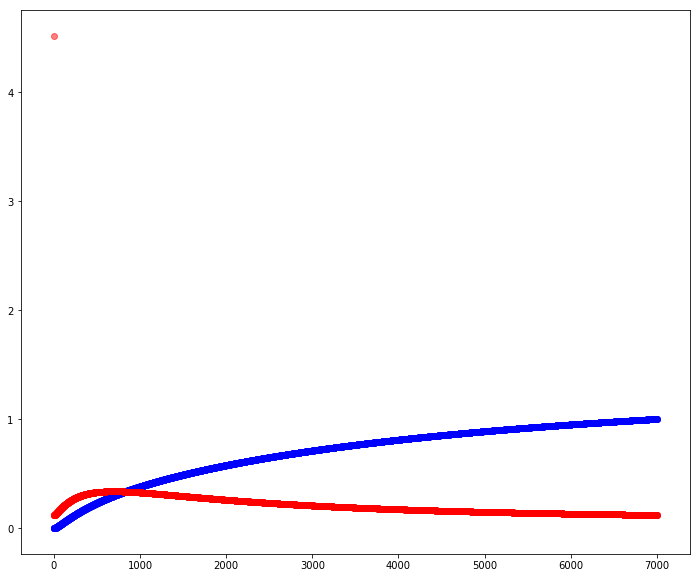

In [10]:
def ridge_r(X, y, num_iters, step_size):

 X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

 training_errors = []
 testing_errors = []
 alphas = range(0, num_iters, step_size)
 for alpha in alphas:

   ridge_reg_split = Ridge(alpha = alpha).fit(X_train, y_train)
   training_error = mean_squared_error(y_train, ridge_reg_split.predict(X_train))
   training_errors.append(training_error)
   testing_error = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
   testing_errors.append(testing_error)

 fig, ax = plt.subplots(figsize = (12, 10))
 plt.scatter(alphas, training_errors, color = 'b', alpha = 0.5)
 plt.scatter(alphas, testing_errors, color = 'r', alpha = 0.5)
 plt.show()

ridge_r(X1, y1, 7000, 1)

# Resources and stretch goals

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022

Stretch goals:
- Revisit past data you've fit OLS models to, and see if there's an `alpha` such that ridge regression results in a model with lower MSE on a train/test split
- Yes, Ridge can be applied to classification! Check out [sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), and try it on a problem you previous approached with a different classifier (note - scikit LogisticRegression also automatically penalizes based on the $L^2$ norm, so the difference won't be as dramatic)
- Implement your own function to calculate the full cost that ridge regression is optimizing (the sum of squared residuals + `alpha` times the sum of squared coefficients) - this alone won't fit a model, but you can use it to verify cost of trained models and that the coefficients from the equivalent OLS (without regularization) may have a higher cost